# Digit Recognizer
by Duygu Can

The goal of the project is to correctly identify digits from a dataset of tens of thousands of handwritten images. Different machine learning algorithms will be studied on the toy dataset of MNIST (Modified National Institute of Standards and Technology) [1]. The MNIST database is a large and mixed dataset composed of hand-written digits by high school students and US Census Bureu. It is composed of 70000 images (60000 for training and 10000 for test). This data set is already avaible in Scikit-Learn library with the same structure of the creators LeCun  et al. [2].

![Sample images from MNIST](MnistExamples.png)

## Data Pre-processing

At first the required libraries and packages should be imported for future use.

In [4]:
from __future__ import print_function
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import keras
%matplotlib inline
from sklearn.manifold import TSNE
from time import time, clock
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from sklearn.preprocessing import MinMaxScaler
from sklearn.datasets import fetch_mldata
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten,  BatchNormalization, Conv2D, MaxPooling2D
from keras import backend as K
from pylab import *
from keras.callbacks import LearningRateScheduler
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix

During development of the code, obtaining reproducible results for comparision is essential. This is the only way we can compare results from different runs and determine which parameter set gives best result. So following code snipet is borrowed from [Keras FAQ](https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development).

In [9]:
import numpy as np
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926

import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.

np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.

rn.seed(12345)

# Force TensorFlow to use single thread.
# Multiple threads are a potential source of
# non-reproducible results.
# For further details, see: https://stackoverflow.com/questions/42022950/which-seeds-have-to-be-set-where-to-realize-100-reproducibility-of-training-res

session_conf = tf.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)

from keras import backend as K

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed

tf.set_random_seed(1234)

sess = tf.Session(graph=tf.get_default_graph(), config=session_conf)
K.set_session(sess)

The MNIST dataset is downloaded from [mldata.org](http://www.mldata.org/repository/) using *fetch_mldata* function. Let's have a quick look at the structure of the data.

In [10]:
mnist = fetch_mldata('MNIST original')
X, y = mnist["data"].astype("float32"), mnist["target"] # features with utf8 data type converted to floating numbers
print("Shape of the features: ",X.shape)
print("Shape of the labels: ",y.shape)

Shape of the features:  (70000, 784)
Shape of the labels:  (70000,)


In [11]:
# Parameters to be changed for the new dataset
height = 28
width = 28
channels = 1
inputShape = (height, width, channels)
n_inputs = height * width
#randomSeed = 42 #fixed for reproducibility
testSize=1/7.0


There are  70000 instances with 784 features. The digits are size normalized each consisting of 28x28 pixels (724 features). Each feature represents pixel’s gray-scale intensity, from 0 (white) to 255 (black). Here I visualized a custom image from the training set:

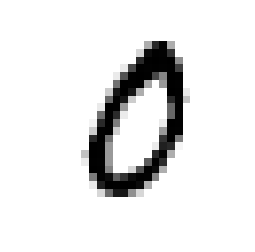

In [12]:
digitIndex = X[666]
digitImage = digitIndex.reshape(height, width) # Flat feature vector reshaped to 28x28 array
plt.imshow(digitImage, cmap = matplotlib.cm.binary, # Display using Matplotlib's imshow function
interpolation="nearest")
plt.axis("off")
plt.show()

And the related label is: 

In [13]:
print(y[666])

0.0


Uniform distribution of the occurance frequencies of the digits implies that each one is represented in the set with equal chances. So, the set seems to be balanced.

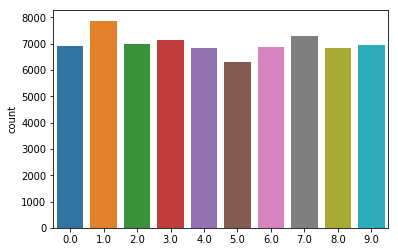

In [14]:
sns.countplot(y)
#subplot(1,3,1)
#sns.countplot(y_train)
#title("Training Set")
#subplot(1,3,3)
#sns.countplot(y_test)
#title("Test Set")
plt.show()

Grayscale normalization must be performed to reduce the effect of illumination's differences. Not to destroy the sparseness charachteristics of the data, mean value is not subtracted from each instance. Min-Max scaling is applied instead. Furthermore CNNs are said to converge faster on 0-1 range rather than 0-255 range [4]. 

In [15]:
#X -= np.mean(X, axis = 0) # mean subtraction 
scaler = MinMaxScaler()
scaler.fit(X) 
X = scaler.transform(X)

#Comment out the following lines not to see the effect of the 0-1 normalization
print("per-feature minimum after scaling of the set:\n {}".format(np.unique(X.min(axis=0))))
print("per-feature maximum after scaling of the set:\n {}".format(np.unique(X.max(axis=0))))

per-feature minimum after scaling of the set:
 [0.]
per-feature maximum after scaling of the set:
 [0.         0.99999994 1.        ]


## Dimentionality Reduction

MNIST dataset consists of a 784 features (columns), it is perfect to introduce dimensionality reduction methods. PCA or LDA are the most popular methods for dimentionality reduction but there topology preserving capabilities of t-SNE [19, 20]. Since PCA is a linear algorithm, it fails to interpret complex polynomial relationship between features because it focuses on placing dissimilar points apart from each other. However, t-SNE is a nonlinear algorithm that can capture both local and the global structure of the data [21]. 

Stochastic Neighbor Embbeding (SNE) algorithm converts the distance between the points into probability of similarity of points. Similarity is calculated as conditional probalitity using Gaussian distribution. In the same manner, probability of similarity is calculated low dimentional representations of those points. In a perfect representation those two conditional probabilities must be the same. Ideally, SNE tries to minimize the difference between those two probabilities of similarity between high-dimentional representation and low-dimentional representaiton.

Sklearn documentation for t-SNE recommends to use another feature reduction method such as PCA before  to reduce the number of dimensions to a reasonable amount (e.g. 50) if the number of features is very high. This will suppress some noise and speed up the computation of pairwise distances between samples [22].

The dataset is splitted to train and test parts in a stratified wat so that each class will be represented similarly.

In [17]:
# PCA
from sklearn.decomposition import PCA
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = testSize,stratify=y, random_state=42)
#for n in [25, 50, 75, 100, 150]
nComp = 150
t0 = time.time()
pca = PCA(n_components=nComp)
pca.fit(X_train) 
X_train_trans = pca.transform(X_train) 
exp_Var = pca.explained_variance_ratio_.cumsum()
print(exp_Var)
print("Time Passed: %f s"%(time.time()-t0))

[0.09734727 0.16881344 0.23022482 0.28431505 0.33313936 0.37615907
 0.40898344 0.43792766 0.46544018 0.4889192  0.5099315  0.5303275
 0.5474365  0.5644161  0.5802399  0.5951342  0.6083341  0.6211185
 0.6329766  0.6444837  0.6551802  0.6652844  0.67484796 0.68396413
 0.6928279  0.7012153  0.7093403  0.71718353 0.7245721  0.73147875
 0.73805726 0.7445211  0.75053996 0.7563983  0.76207495 0.76751804
 0.77256185 0.7774368  0.78223956 0.7869211  0.7914712  0.7959205
 0.80009884 0.804067   0.80791146 0.811671   0.81530046 0.8187932
 0.8221753  0.8253749  0.8285373  0.8316476  0.8346218  0.83748966
 0.8403147  0.8430107  0.845695   0.8482609  0.85081005 0.8532629
 0.8556572  0.8580423  0.8603376  0.8625409  0.86468226 0.8667406
 0.8687702  0.8707213  0.87263876 0.87451875 0.87638885 0.8781915
 0.87995946 0.8816947  0.8833417  0.8849693  0.8865788  0.8881259
 0.8895989  0.89101875 0.8924283  0.8938294  0.89522094 0.896574
 0.8978975  0.8992143  0.9005122  0.9017686  0.90299976 0.9042028
 0.905

The first 86 components explains 90% of the variance in the training set.

Text(0.5,1,'Cumulative Variance Explained')

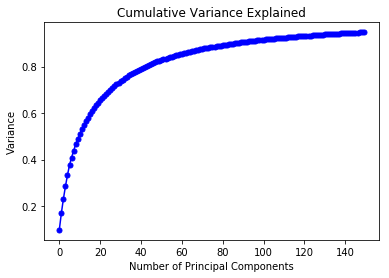

In [18]:
# Plot
import numpy as np
import matplotlib.pyplot as plt
x=['PC %s' %i for i in range(1,151)]

plt.plot(exp_Var, linestyle='-', marker = 'o', color='b', markersize=5)
plt.xlabel('Number of Principal Components')
plt.ylabel('Variance')
plt.title('Cumulative Variance Explained')


According to plot above first 50 principal components explain more than 80% of the variance. But to be on the safe side we can take 75 components too. Both will be tried.

In [60]:
# PCA
from sklearn.decomposition import PCA

t0 = time.time()
pca50 = PCA(n_components=50)
pca75 = PCA(n_components=75)
pca50.fit(X_train) 
pca75.fit(X_train) 
X_train_trans50 = pca50.transform(X_train) 
X_test_trans = pca50.transform(X_test)
X_train_trans75 = pca75.transform(X_train) 
exp_Var50 = pca50.explained_variance_ratio_.cumsum()
exp_Var75 = pca75.explained_variance_ratio_.cumsum()
print("First 50 components explains %f percentage of the variance in the data"%exp_Var50[-1])
print("First 75 components explains %f percantage of the variance in the data"%exp_Var75[-1])
print("Time Passed: %f s"%(time.time()-t0))

First 50 components explains 0.825308 percentage of the variance in the data
First 75 components explains 0.883298 percantage of the variance in the data
Time Passed: 6.853235 s


Initialization of embedding is chosen as PCA since it is said to be more globally stable than random initialization [22]

In [20]:
# tSNE
tsne = TSNE(n_components=3, init='pca', random_state=42)
start = clock()
tsne_results50 = tsne.fit_transform(X_train_trans50)
#tsne_results75 = tsne.fit_transform(X_train_trans75)
print("Time Passed: %f s"%(time.time()-t0))

Time Passed: 10001.059793 s


In [33]:
# open a (new) file to write
outF = open("tsne_results50.txt", "w")
for line in tsne_results50:
     outF.writelines(str(line))
#close file
outF.close()

In [34]:
import pickle
with open('tsne_results50_OUT', 'wb') as fp:
    pickle.dump(tsne_results50, fp)
    
with open ('tsne_results50_OUT', 'rb') as fp:
    tsne_results50_reread = pickle.load(fp)
    
print(tsne_results50_reread)

[[ 16.640875     7.272221     4.5193267 ]
 [ -9.692024    10.4284935    7.6380982 ]
 [ -4.4752874   -6.928149    -6.3486004 ]
 ...
 [-15.95446     -3.5219615   -9.217222  ]
 [ -0.07323801   1.9646802  -13.3457575 ]
 [  7.1000295   -2.1199512   11.037359  ]]


When compared to PCA, t-SNE is computationally expensive. So, only first 50 PCA transformed vectors is passed to the t-SNE reduction. The resulting vectors will be used is SVM algorithm. For perfomance comparision the same procedure will be applied to the test set.

In [37]:
# PCA + tSNE on X_test
X_test_trans50 = pca50.transform(X_test) 
tsne = TSNE(n_components=3, init='pca', random_state=42)
start = clock()
tsne_TESTresults50 = tsne.fit_transform(X_test_trans50 )
#tsne_results75 = tsne.fit_transform(X_train_trans75)
print("Time Passed: %f s"%(time.time()-t0))

# open a (new) file to write
outF = open("tsne_TESTresults50.txt", "w")
for line in tsne_results50:
     outF.writelines(str(line))
#close file
outF.close()

import pickle
with open('tsne_TESTresults50_OUT', 'wb') as fp:
    pickle.dump(tsne_results50, fp)
    

KeyboardInterrupt: 

After running the chunk above once and obtaining the t-SNE transformed embedding vectors for the test set, it ran again by accident. Hopefully, the vectors were pickled to an output file. The recovered vectors are listed below.

In [39]:
with open ('tsne_TESTresults50_OUT', 'rb') as fp:
    tsne_TESTresults50 = pickle.load(fp)
    
print(tsne_TESTresults50)

[[ 16.640875     7.272221     4.5193267 ]
 [ -9.692024    10.4284935    7.6380982 ]
 [ -4.4752874   -6.928149    -6.3486004 ]
 ...
 [-15.95446     -3.5219615   -9.217222  ]
 [ -0.07323801   1.9646802  -13.3457575 ]
 [  7.1000295   -2.1199512   11.037359  ]]


## SVM on MNIST Dataset

Support vector machines (SVMs) are also used for classification. However, when number of features is much greater than the number of samples they are prone to over-fitting. That is why dimensionality reduction is applied before classification with SVM algorithm.

In [43]:
from sklearn.svm import SVC
clf_C1 = SVC(kernel = "linear", C=1) #regularization parameter is chosen as default (i.e C=1)
start = clock()
clf_C1 = clf_C1.fit(tsne_results50, y_train) #fit the model on the t-SNE transformed vectors
print("Time Passed: %f s"%(time.time()-t0))

Time Passed: 35434.652950 s


In [54]:
from sklearn import metrics
from sklearn.metrics import accuracy_score
y_predicted = clf_C1.predict(tsne_TESTresults50)

# performance
print("Classification report for %s" % clf_C1)
print()
print("Accuracy Score")
print(accuracy_score(y_test, y_predicted))
print()
print(metrics.classification_report(y_test, y_predicted))
print()
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, y_predicted))

Classification report for SVC(C=1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy Score
0.1969

             precision    recall  f1-score   support

        0.0       0.17      0.19      0.18       986
        1.0       0.11      0.13      0.12      1125
        2.0       0.00      0.00      0.00       999
        3.0       0.00      0.00      0.00      1020
        4.0       0.00      0.00      0.00       975
        5.0       0.79      0.91      0.85       902
        6.0       0.07      0.07      0.07       982
        7.0       0.02      0.02      0.02      1042
        8.0       0.84      0.74      0.79       975
        9.0       0.01      0.01      0.01       994

avg / total       0.19      0.20      0.19     10000


Confusion matrix
[[187   1   0   2   0   1 794   0   1   0]
 [  1 144   0   3   0   

SVM with linear kernel and  C = 1 has low sensivity and low positive predictive value. Upon tuning C-parameter the model might be improved. 

In [55]:
clf_C01 = SVC(kernel = "linear", C=0.1) #regularization parameter is chosen as default (i.e C=1)
start = clock()
clf_C01 = clf_C01.fit(tsne_results50, y_train) #fit the model on the PCA transformed 50 vectors
print("Time Passed: %f s"%(time.time()-t0))
y_predicted01 = clf_C01.predict(tsne_TESTresults50)

# performance
print("Classification report for %s" % clf_C01)
print()
print("Accuracy Score")
print(accuracy_score(y_test, y_predicted01))
print()
print("Classification Report")
print(metrics.classification_report(y_test, y_predicted01))
print()
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, y_predicted01))

Time Passed: 40753.595985 s
Classification report for SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy Score
0.1968

Classification Report
             precision    recall  f1-score   support

        0.0       0.17      0.19      0.18       986
        1.0       0.11      0.13      0.12      1125
        2.0       0.00      0.00      0.00       999
        3.0       0.00      0.00      0.00      1020
        4.0       0.00      0.00      0.00       975
        5.0       0.79      0.91      0.85       902
        6.0       0.07      0.07      0.07       982
        7.0       0.02      0.02      0.02      1042
        8.0       0.84      0.74      0.79       975
        9.0       0.01      0.01      0.01       994

avg / total       0.19      0.20      0.19     10000


Confusion matrix
[[186   1   0  

The parameter C controls the trade-off between the margin and the size of the slack variables. Unfortunately decreasing C to for SVM to loose the classification error didn't help. Increasing C to 10 to harden the margins didn't work either.

In [56]:
clf_C10 = SVC(kernel = "linear", C=10) #regularization parameter is chosen as default (i.e C=1)
start = clock()
clf_C10 = clf_C10.fit(tsne_results50, y_train) #fit the model on the t-SNE transformed vectors
print("Time Passed: %f s"%(time.time()-t0))
y_predicted10 = clf_C10.predict(tsne_TESTresults50)

# performance
print("Classification report for %s" % clf_C10)
print()
print("Accuracy Score")
print(accuracy_score(y_test, y_predicted10))
print()
print("Classification Report")
print(metrics.classification_report(y_test, y_predicted10))
print()
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, y_predicted10))

Time Passed: 41226.192374 s
Classification report for SVC(C=10, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy Score
0.1968

Classification Report
             precision    recall  f1-score   support

        0.0       0.17      0.19      0.18       986
        1.0       0.11      0.13      0.12      1125
        2.0       0.00      0.00      0.00       999
        3.0       0.00      0.00      0.00      1020
        4.0       0.00      0.00      0.00       975
        5.0       0.79      0.91      0.85       902
        6.0       0.07      0.07      0.07       982
        7.0       0.02      0.02      0.02      1042
        8.0       0.84      0.74      0.79       975
        9.0       0.01      0.01      0.01       994

avg / total       0.19      0.20      0.19     10000


Confusion matrix
[[187   1   0   

Stacking PCA and t-SNE together didn't resulted well for MNIST dataset as seen from the off-diagonal terms of the confusion matrix. 0.1, 1 and 10 is chosen for C in SVM with linear kernels. All models gave a precision of 19% and a recall of 20%. This poor performance might be due to not tuning the learning rate. Alternatively, just using 3 embedding vectors was not enough to represent all the features in the data. Since t-SNE works slow on MNIST set I didn't experiment more with the algorithm, it is totaly taken out of the game.

### PCA (w/ 50 PCs) + SVM with Linear and RBF Kernels

Instead of stacking PCA with t-SNE, PCA reduced vectors directly given to the SVM classifier. The results are improved when first 50 principal components are used. Remember that they were able to explain more than 80% of the variance in the data.

#### Linear Kernel

When just PCA is used, an accuracy score of 93% is obtained. Recall is also boosted to 93%. But there is still a number of false positives and false negatives.

In [63]:
clf= SVC(kernel = "linear", C=0.1) #regularization parameter is chosen as default (i.e C=1)
start = clock()
#X_testTrans= pca50.transform(X_test)
clf = clf.fit(X_train_trans50, y_train) #fit the model 
print("Time Passed: %f s"%(time.time()-t0))
y_predictedPCA = clf.predict(X_test_trans)

# performance
print("Classification report for %s" % clf)
print()
print("Accuracy Score")
print(accuracy_score(y_test, y_predictedPCA))
print()
print("Classification Report")
print(metrics.classification_report(y_test, y_predictedPCA))
print()
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, y_predictedPCA))

Time Passed: 7220.950648 s
Classification report for SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy Score
0.9323

Classification Report
             precision    recall  f1-score   support

        0.0       0.95      0.98      0.97       986
        1.0       0.96      0.99      0.97      1125
        2.0       0.93      0.92      0.92       999
        3.0       0.90      0.91      0.90      1020
        4.0       0.92      0.94      0.93       975
        5.0       0.90      0.89      0.90       902
        6.0       0.95      0.97      0.96       982
        7.0       0.95      0.95      0.95      1042
        8.0       0.93      0.89      0.91       975
        9.0       0.92      0.89      0.90       994

avg / total       0.93      0.93      0.93     10000


Confusion matrix
[[ 966    0    0

### SVM RBF Kernel with 50 PCs

Since RBF kernel is a non-linear kernel it captures features of the digits better than the linear kernel. When 50 PCs are passed to the SVM classifier precision, recall and F1 score which is a weighted average of first two, are all increased to 97%. I think this is the success on non-linear kernel working on MNIST.

In [64]:
clf2= SVC( C=0.1) #regularization parameter is chosen as default (i.e C=1)
start = clock()
#X_testTrans= pca50.transform(X_test)
clf2 = clf2.fit(X_train_trans50, y_train) #fit the model on the PCA transformed vectors
print("Time Passed: %f s"%(time.time()-t0))
y_predictedPCA2 = clf2.predict(X_test_trans)

# performance
print("Classification report for %s" % clf2)
print()
print("Accuracy Score")
print(accuracy_score(y_test, y_predictedPCA2))
print()
print("Classification Report")
print(metrics.classification_report(y_test, y_predictedPCA2))
print()
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, y_predictedPCA2))

Time Passed: 7423.275108 s
Classification report for SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy Score
0.9654

Classification Report
             precision    recall  f1-score   support

        0.0       0.98      0.99      0.98       986
        1.0       0.98      0.98      0.98      1125
        2.0       0.97      0.96      0.97       999
        3.0       0.96      0.95      0.96      1020
        4.0       0.97      0.96      0.96       975
        5.0       0.97      0.96      0.96       902
        6.0       0.97      0.98      0.98       982
        7.0       0.97      0.96      0.96      1042
        8.0       0.96      0.96      0.96       975
        9.0       0.94      0.94      0.94       994

avg / total       0.97      0.97      0.97     10000


Confusion matrix
[[ 975    1    0   

### SVM RBF Kernel with 75 PCs

Interestingly when 75 principal components are passed to the same classifier, the performance degraded. This might be due to overfitting. While 50 vectors are just enough, with 75 vectors model fitted to the noise in the data.

In [65]:
clf3= SVC( C=0.1) #regularization parameter is chosen as default (i.e C=1)
start = clock()
#X_testTrans= pca50.transform(X_test)
clf3 = clf3.fit(X_train_trans75, y_train) #fit the model on the PCA transformed vectors
print("Time Passed: %f s"%(time.time()-t0))
y_predictedPCA3 = clf3.predict(pca75.transform(X_test))

# performance
print("Classification report for %s" % clf3)
print()
print("Accuracy Score")
print(accuracy_score(y_test, y_predictedPCA3))
print()
print("Classification Report")
print(metrics.classification_report(y_test, y_predictedPCA3))
print()
print("Confusion matrix")
print(metrics.confusion_matrix(y_test, y_predictedPCA3))

Time Passed: 49607.710867 s
Classification report for SVC(C=0.1, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=False, random_state=None, shrinking=True,
  tol=0.001, verbose=False)

Accuracy Score
0.9596

Classification Report
             precision    recall  f1-score   support

        0.0       0.97      0.99      0.98       986
        1.0       0.98      0.98      0.98      1125
        2.0       0.96      0.95      0.96       999
        3.0       0.95      0.94      0.94      1020
        4.0       0.96      0.96      0.96       975
        5.0       0.95      0.96      0.96       902
        6.0       0.97      0.98      0.97       982
        7.0       0.97      0.96      0.96      1042
        8.0       0.95      0.95      0.95       975
        9.0       0.94      0.93      0.93       994

avg / total       0.96      0.96      0.96     10000


Confusion matrix
[[ 974    1    1  

## CNN on MNIST Database

"In machine learning, a convolutional neural network (CNN, or ConvNet) is a class of deep, feed-forward artificial neural networks, most commonly applied to analyzing visual imagery" [23]. Differing from neural networks (NNs) which have fully connected layers, CNNs are able to take into account the spatial structure of the images. The idea of *receptive field* is borrowed from the works of Hubel and Wiesel, 1957. Networks layers are stacked over eachother inspired by the columnar structure of the neurons in the visual cortex. Each neuron in the first hidden layer will be connected to a small region of the input neurons. Each connection learns a weight and the hidden neuron learns an overall bias as well. as you go deeper into the network, the filters begin to have a larger and larger receptive field, which means that they are able to consider information from a larger area of the original input volume (another way of putting it is that they are more responsive to a larger region of pixel space). We can detect these high level features, the icing on the cake is attaching a fully connected layer to the end of the network which outputs an N dimensional vector where N is the number of classes. 

### Data Pre-processing
According to Géron, the first 60000 images in the dataset of Scikit-Learn is reserved for training and the last 10000 is for test [3]. I was considering to split the set in the same way to compare prediction accuracy with the book but later I decided to split randomly. Training set further splitted for validation, too. A small fraction (15%) of the training set is reserved for validation, the rest will be used for training the model. Since the labels seems to be well balanced, one can hope that random split will not cause any over-representation of some labels in the validation set. To be on the safe side stratified splitting is enabled. 

In [28]:
#X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size = testSize,stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.15,stratify=y_train)
print(X_train.shape)
print(X_test.shape)
print(X_val.shape)

(51000, 784)
(10000, 784)
(9000, 784)


The images with 28x28 pixels are stored as flat arrays of 784 values. They need to be reshaped to square matrices before feeding CNNs. Notice that there is only one channel since the images are grayscaled.

In [29]:
X_train = X_train.reshape(-1,height,width,channels) # dimension (60000) is inferred by setting the first element to -1
X_test = X_test.reshape(-1,height,width,channels)
X_val = X_val.reshape(-1,height,width,channels)

Digit labels (one, two, three,...) are nominal categorical variables, indeed. Since logical consequence of NNs is that perceptrons only work with numerical data, they should be converted to numerical variables through one-hot encoding. Thus, one boolean column for each category will be created. Only one of these columns could take on the value 1 for each sample. 

In [30]:
classNum = len(np.unique(y_train)) # number of unique labels is counted to determine the # of classes
y_train = to_categorical(y_train, num_classes = classNum)
#y_test = to_categorical(y_test, num_classes = classNum)
y_val = to_categorical(y_val, num_classes = classNum)

## CNN Model

The CNN model is constructed via *Sequantial API* model, which is a stack of layers, of *Keras Framework*. Output of each layer is input of the next. The input image is passed to the first layer by *input_shape* argument. The neurons of a convolutional layer is not connectted to the every pixel of its input layer but only to the ones in the *receptive field*. A receptive field is rectangular area slided across the input image with defined *stride* steps. Through a filter weighted sums are calculated and feature map is created. This stacked architecture of convolutional layers makes it easy for CNN to focus on local features in the first hidden layer, then assemble them to learn more complex features in the next hidden layer. Gloabla features of the image are deduced via this combined approach.

As we go deep in the network, the size of the layers shrinks (due to convolution) and network starts to ignore features at the edges (pixels with no neighbours). To avoid these both *same padding* is used. Simply a buffer layer of zeros are put around the input image, so that the size of the output layer will be the same with the input layer.

While initializing shared filter weights at each convolutional layer *Truncated Normal* is used. In this initializer, the randomly chosen values belongs to normal distribution but the values more than two standard deviations from the mean are discarded and re-drawn. This is the recommended initializer for neural network weights and filters according to the Keras documentation [9].

Immediately after each convolutional layer, an activation layer is applied. Here, rectified linear unit (ReLu) is used for the sake of computational efficiency (except softmax is used in the last layer). ReLu outperforms other conventional non-linear activation functions such as *sigmoid*  and *tanh* [8]. ReLu also said to be the solution of the *vanishing gradient* problem which stops the neural network from further training. In this layer f(x) = max(0, x) is applied to all of the values in the input. All negative activations is replaced by zero. So, nonlinearity is introduced to the system without affecting the receptive fields of the convolutional layer.

Pooling layer is another key element of CNNs. Output of the previous layer is down-sampled to reduce computational load and number of parameters. So the risk of over-fitting is reduced somehow. Shirinking the input image also introduces a level of location invariance, so that the neural network can tolarate a little bit of image shift [2]. Here *MaxPooling* is used as aggregation function. Just like in convolutional layer, a rectangular window with defined size, padding and stride is slided across the input layer, and max input value in each kernel makes it to the next layer (2x2 with no padding and 2 strides). The others are just dropped. 

When a complex model fits the noise in the data instead of the underlying relationship of the features overfitting occurs. This can be avoided by a regularization technique. Here brutal *dropout* technique is employed because of its advantageous training speed[10]. Dropout consists in randomly setting a fraction rate of input units to 0 at each update during training time, which helps prevent overfitting. At every training step each neuron in the input layer has a probability to be dropped out. These ignored neurons can also be active in the next step. Network trained with dropout becomes more robust because in order to do other neurons' jobs when necessary, neurons learn to be sensitive not only to their input neurons but others' too. At the end the network generalizes better.

Using an initializer with ReLU reduces the vanishing/exploiding gradient problem at the beginnig of the training but not during the training. The  input distribution of each layer changes during training as the parameters of the previous layer changes leading to a drop in the learning rate. This probles is addressed as *Internal Covariate Shift* in the 2015 paper of Ioffe and Szegedy and normalization for each training mini-batch is suggested [11]. The authors claim this method not only is a solution vanishing/exploiding gradient problem but also acts somehow as a regularization technique that eliminates the need for dropout. Upon experiment, the same effect is observed and dropout layers after convolutional layers are excluded. Before activation function of each layer inputs are zero-centered, normalized, scaled and shifted by batch-normalization scaling and shifting parameters per layer. The required means and standard deviations of the inputs for zero-centering and normalization steps are estimated from the current mini-batch.

Finally the output of the last pooling layer is flattened to feed the fully connected layers at the end. High level features coming from the activation maps of the previous layer are detected. In the final *dense* layer the net output is given as probability distribution of each class. In the softmax approach the class with highest probability is chosen.

In [31]:
# parameters to be optimized
k1 = 3 # Kernel dimension of the 1st layer
f1 = 8 # the number of output filters in the 1st layer
k2 = 3 # Kernel dimension of the 2nd layer
f2 = 16 # the number of output filters in the 2nd layer
k3 = 5 # Kernel dimension of the 3rd layer
f3 = 32 # the number of output filters in the 3rd layer
k4 = 5 # Kernel dimension of the 3rd layer
f4 = 64 # the number of output filters in the 3rd layer
d_conv = 0.5 # dropout rate of the CNN layers
d_dense = 0.5 # dropout rate of the ANN layer
DR = 0.01 # decay rate of the optimizer
Epochs = 15 # 
batchSize = 128 # number of randomly taken samples from features and labels to feed into each epoch until an epoch limit is reached.

In [32]:
model = Sequential()
model.add(Conv2D(filters=f1,kernel_size=(k1,k1),padding='Same',kernel_initializer="TruncatedNormal",activation ='relu', 
                 input_shape = inputShape))
model.add(BatchNormalization())
model.add(Conv2D(filters=f2,kernel_size=(k2,k2),padding='Same',kernel_initializer="TruncatedNormal",activation ='relu'))

model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(d_conv))


model.add(Conv2D(filters = f3, kernel_size = (k3,k3),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(Conv2D(filters = f4, kernel_size = (k4,k4),padding = 'Same', activation ='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Dropout(d_conv))


model.add(Flatten())
model.add(Dense(256, activation = "relu"))
model.add(Dropout(d_dense))
model.add(Dense(classNum, activation = "softmax"))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 8)         80        
_________________________________________________________________
batch_normalization_1 (Batch (None, 28, 28, 8)         32        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 28, 28, 16)        1168      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 16)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 14, 14, 32)        12832     
_________________________________________________________________
batch_normalization_2 (Batch (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_4 (Conv2D)            (None, 14, 14, 64)        51264     
__________

In [33]:
#from keras.utils import plot_model
#plot_model(model, to_file='model.png')

## Compilation

Before training the model, the learning process is needed to be configured. Adam optimizer, which is a combination of *Gradient Descent with momentum* and *RMSProp* is chosen because it is effective. Authors of ADAM observed that exponetial averages of past gradients and variance of the gradients (first and secon momentum) decay towars zero, so they come up with a bias correction for these terms [12]. In Keras library learning rate is updated with a reciprocal fucntion of decay rate at each *epoch* [14]. So, learning rate decreased as it get closer to the optimal solution.

As a cost function *categorical cross entropy* is chosen since it penalizes bad predictions much more, producing larger gradients and thus converging faster. The cross entropy between estimated probability and target probability will be minimized. Default learning rate of Adam optimizer is defined as 0.001 in Keras. It can be decreased in every epoch  by setting a *decay* rate to ensure convergence. Alternatively, *LearningRateScheduler* can be used to decrease the learning rate by %10 at each epoch as it is in 

In [34]:
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adam(), #instead of annealer decay = DR can be set, too
              metrics=['accuracy'])
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

## Data Augmentation

To make model more robust, the data set is expanded with *ImageDataGenerator*. Noise added, images are distorted by shifting, rotating and flipping. Thes transformations are done because change in the perpective can change the apparent shape of the digits. Here images are let to rotate 20 degrees, randomly zoomed to 20%, shifted up to 20% of their height and width and flipped vertically and horizontally.

In [35]:
datagen = ImageDataGenerator(
        rotation_range=20,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.2,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.2,  # randomly shift images vertically (fraction of total height)
        horizontal_flip=False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train)

In [36]:
# Fit the model
history = model.fit_generator(datagen.flow(X_train,y_train, batch_size=batchSize),
                              epochs = Epochs, validation_data = (X_val,y_val),
                              verbose = 1, steps_per_epoch=X_train.shape[0] // batchSize
                              , callbacks=[annealer])

Epoch 1/15
398/398 [==============================] - 210s 527ms/step - loss: 0.6379 - acc: 0.8019 - val_loss: 0.3321 - val_acc: 0.9074
Epoch 2/15
398/398 [==============================] - 211s 531ms/step - loss: 0.2236 - acc: 0.9351 - val_loss: 0.1064 - val_acc: 0.9701
Epoch 3/15
398/398 [==============================] - 211s 530ms/step - loss: 0.1560 - acc: 0.9559 - val_loss: 0.0560 - val_acc: 0.9847
Epoch 4/15
398/398 [==============================] - 207s 519ms/step - loss: 0.1237 - acc: 0.9642 - val_loss: 0.0780 - val_acc: 0.9789
Epoch 5/15
398/398 [==============================] - 216s 543ms/step - loss: 0.1024 - acc: 0.9710 - val_loss: 0.1875 - val_acc: 0.9508
Epoch 6/15
398/398 [==============================] - 216s 542ms/step - loss: 0.0922 - acc: 0.9732 - val_loss: 0.0487 - val_acc: 0.9863
Epoch 7/15
398/398 [==============================] - 214s 537ms/step - loss: 0.0819 - acc: 0.9778 - val_loss: 0.0373 - val_acc: 0.9881
Epoch 8/15
398/398 [============================

In [21]:
#from keras.models import load_model

#model.save('my_model1.h5')  # creates a HDF5 file 'my_model.h5'
#del model  # deletes the existing model

# returns a compiled model
# identical to the previous one
#model = load_model('my_model.h5')

## Training and Validation Performance of CNN Model

As it is seen from the final epoch, training accuracy is smaller than validation accuracy. This is due to dropout regulizer. Training accuracy is calculated with the network where some units are dropped randomly but validation accuracy is calculated using whole network. When we evaluate the model on the training set, we see that the performance score is increased since the regularization layers are turned-off during the evaluation. This subject is also discussed in FAQ of Keras [17]. 

In [37]:
valLoss, valAcc = model.evaluate(X_val, y_val, verbose=0)
trainLoss, trainAcc = model.evaluate(X_train, y_train, verbose=0)
print("Validation Loss: {0:.6f}, Validation Accuracy: {1:.6f}".format(valLoss, valAcc))
print("Train Loss: {0:.6f}, Train Accuracy: {1:.6f}".format(trainLoss, trainAcc))

Validation Loss: 0.031257, Validation Accuracy: 0.992222
Train Loss: 0.018821, Train Accuracy: 0.994549


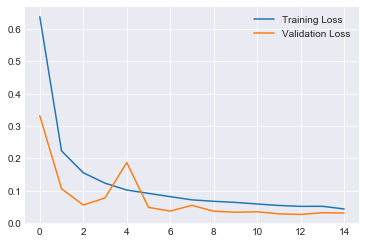

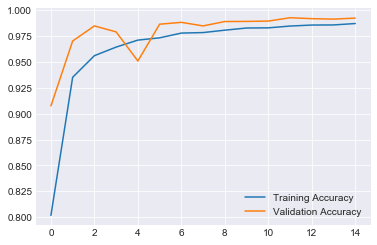

In [38]:
sns.set_style("darkgrid")
plt.plot(history.history['loss'], label = "Training Loss")
plt.plot(history.history['val_loss'], label = "Validation Loss")
plt.legend()
plt.show()
plt.plot(history.history['acc'],label = "Training Accuracy")
plt.plot(history.history['val_acc'], label = "Validation Accuracy")
plt.legend()
plt.show()


### Confusion Matrix of the Test Set


At first run , the model predicted 85 of actual 9's as 6 and 47 of actual 6's as 9. It also confused 5's with 2's.This systematic error is due to turning on the *flip* arguments in the data augmentation step, previously. It's no surprise to miss true classification of some symmetric digits under horizontal or vertical flips. The old confusion matrix with flip can be seen here:![](files/CM_w_flip.png)

When the problem of flip is solved loss and accuracy is improved. It is also apperant in the confusion matrix since number of false positives and false negatives are decreased. The structure of the matrix became more diagonal.

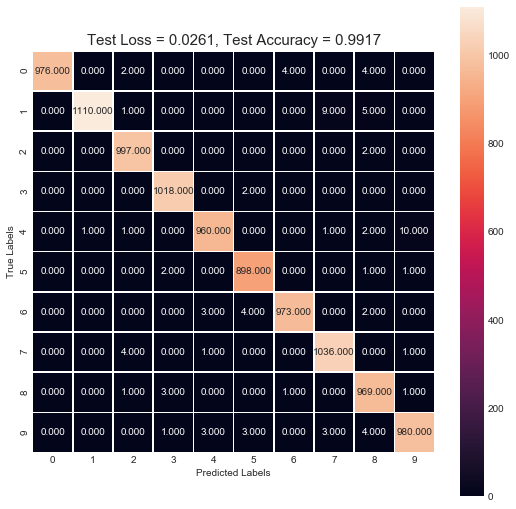

In [39]:
pred = model.predict(X_test) # Predict values of the test set
y_testCat = to_categorical(y_test, num_classes = classNum) 
testLoss, testAcc = model.evaluate(X_test, y_testCat, verbose=0)
#print(testLoss,testAcc)

pred1hot = np.argmax(pred, axis=1) # Convert predicted classes to one hot vectors
y_test1hot = np.argmax(y_testCat, axis=1) # Convert true classes to one hot vectors
cm = confusion_matrix(y_test1hot, pred1hot) #confusion matrix
#print(cm)
plt.figure(figsize=(9,9))
sns.heatmap(cm, annot=True, fmt=".3f", linewidths=.5, square = True);
plt.ylabel('True Labels');
plt.xlabel('Predicted Labels');

plt.title('Test Loss = %.4f, Test Accuracy = %.4f'%(testLoss, testAcc), size = 15);

#plot_confusion_matrix(confusion_mtx, classes = range(10)) 

## Conclusions

In this study performance of SVM and CNN is compared. To make SVM work faster several dimentionality reduction methods are employed. Despite the common sense in the literature, PCA outperformed PCA + t-SNE when combined with SVM. To detect digits in the MNIST dataset, algorithms with non-linear kernels must be used. Number of principal component must be chosen optimally to avoid over-fitting. There is no such a thumbrule that more is better. 97% accuracy and recall scores are obtained when 50 PCs passed to SVM classifier with RBF kernel. The performance can be improved further upon tuning gamma parameter.

CNN model with 4 convolutional layers caped with 2 dense layers at the end is also studied for the sake of comparision. Different regularization techniques such as *max pooling*, *batch normalization* and *dropout* are also employed in the model. To improve the predictive power of the model, dataset must be augmented carefully. With 99.2% of accuracy CNN outperforms, PCA + SVM model as expected. Due to its biological inspired design which mimics the behaviour of visual cortex, CNNs are very effective in areas of image detection and classification.

## References

1. [MNIST database](https://en.wikipedia.org/wiki/MNIST_database)
2. Géron, A. (2017). Hands-on machine learning with Scikit-Learn and TensorFlow: concepts, tools, and techniques to build intelligent systems. " O'Reilly Media, Inc.".
3. [THE MNIST DATABASE of handwritten digits](http://yann.lecun.com/exdb/mnist/)
4. [Introduction to CNN Keras - 0.997 (top 6%)](https://www.kaggle.com/yassineghouzam/introduction-to-cnn-keras-0-997-top-6)
5. [Neural Networks and Deep Learning](http://neuralnetworksanddeeplearning.com/index.html)
6. [A Beginner's Guide To Understanding Convolutional Neural Networks](https://adeshpande3.github.io/adeshpande3.github.io/A-Beginner's-Guide-To-Understanding-Convolutional-Neural-Networks/)
7. [Visual Cortex Cell Recording](https://www.youtube.com/watch?v=Cw5PKV9Rj3o)
8. Xavier Glorot, Antoine Bordes and Yoshua Bengio (2011). [Deep sparse rectifier neural networks](http://proceedings.mlr.press/v15/glorot11a/glorot11a.pdf). AISTATS.
9. [Usage of Initializers](https://keras.io/initializers/#truncatednormal)
10. [Dropout: A Simple Way to Prevent Neural Networks from Overfitting](https://www.cs.toronto.edu/~hinton/absps/JMLRdropout.pdf)
11. [Batch Normalization: Accelerating Deep Network Training by Reducing Internal Covariate Shift](https://arxiv.org/pdf/1502.03167v3.pdf)
12. [Adam: A Method for Stochastic Optimization](https://arxiv.org/abs/1412.6980)
13. [An overview of gradient descent optimization algorithms](http://ruder.io/optimizing-gradient-descent/index.html#conclusion)
14. [keras/keras/optimizers.py](https://github.com/keras-team/keras/blob/master/keras/optimizers.py)
15. [Welcome to deep learning (CNN 99%)](https://www.kaggle.com/toregil/welcome-to-deep-learning-cnn-99)
16. [How can I explain the fact that test accuracy is much higher than train accuracy?](https://www.quora.com/How-can-I-explain-the-fact-that-test-accuracy-is-much-higher-than-train-accuracy)
17. [Why is the training loss much higher than the testing loss?](https://keras.io/getting-started/faq/#why-is-the-training-loss-much-higher-than-the-testing-loss)
18. [How can I obtain reproducible results using Keras during development?](https://keras.io/getting-started/faq/#how-can-i-obtain-reproducible-results-using-keras-during-development)
19. [Interactive Intro to Dimensionality Reduction](https://www.kaggle.com/arthurtok/interactive-intro-to-dimensionality-reduction)
20. [Visualizing Data using t-SNE](http://www.cs.toronto.edu/~hinton/absps/tsne.pdf)
21. [Comprehensive Guide on t-SNE algorithm with implementation in R & Python](https://www.analyticsvidhya.com/blog/2017/01/t-sne-implementation-r-python/)
22. [sklearn.manifold.TSNE](http://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html)
23. [Convolutional neural network](http://www.wiki-zero.net/index.php?q=aHR0cHM6Ly9lbi53aWtpcGVkaWEub3JnL3dpa2kvQ29udm9sdXRpb25hbF9uZXVyYWxfbmV0d29yaw)